# Load data and preprocessing

In [6]:
!git clone https://github.com/dangvu5998/face_emotion_classification.git

Cloning into 'face_emotion_classification'...
remote: Counting objects: 17, done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 0), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [7]:
!unzip all.zip

Archive:  all.zip
  inflating: fer2013.tar.gz          
  inflating: example_submission.csv  


In [9]:
!tar zxvf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [1]:
import os

In [2]:
# os.chdir('face_emotion_classification')
os.chdir('..')

In [3]:
from src.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
faces, emotions = load_fer2013('dataset/fer2013/fer2013.csv')

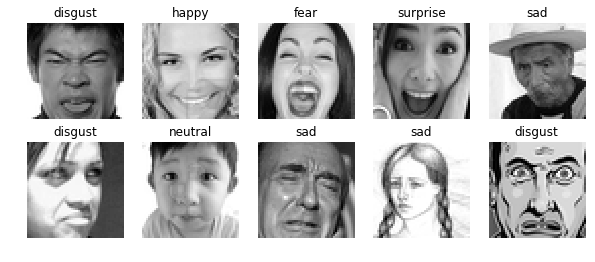

In [8]:
visualize_data(faces, emotions)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
import numpy as np

In [12]:
labels = set(emotions)
label2vec = {}
nd = len(labels) # dimentions of vector
for i, label in enumerate(labels):
    label2vec[label] = np.zeros(nd)
    label2vec[label][i] = 1

In [13]:
label2vec

{'happy': array([1., 0., 0., 0., 0., 0., 0.]),
 'angry': array([0., 1., 0., 0., 0., 0., 0.]),
 'neutral': array([0., 0., 1., 0., 0., 0., 0.]),
 'surprise': array([0., 0., 0., 1., 0., 0., 0.]),
 'fear': array([0., 0., 0., 0., 1., 0., 0.]),
 'sad': array([0., 0., 0., 0., 0., 1., 0.]),
 'disgust': array([0., 0., 0., 0., 0., 0., 1.])}

In [0]:
emotions_encoded = []
for emotion in emotions:
    emotions_encoded.append(label2vec[emotion])
emotions_encoded = np.asarray(emotions_encoded)

In [14]:
a = np.arange(20)

In [0]:
faces = faces.reshape((-1, 48, 48, 1))

In [0]:
faces_train, faces_test, emotions_train, emotions_test = train_test_split(faces, emotions_encoded, test_size=0.1, random_state=42)

# Training

In [17]:
import tensorflow as tf

/home/trivu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
from src.models import simple_cnn

In [19]:
# parameters
batch_size = 32
num_epochs = 10000
input_shape = (48, 48, 1)
validation_split = 0.1
verbose = 1
num_classes = 7
base_path = None
patience = 50
base_path = '../trained_models'

In [0]:
# data generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True    
)

In [20]:
model = simple_cnn(input_shape, num_classes)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
__________

In [0]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(patience=patience)
reduce_lr = ReduceLROnPlateau(patience=int(patience/4), factor=0.1, verbose=1)
model_names = os.path.join(base_path, 'fer2013' + '.{epoch:02d}-{val_acc:.2f}.hdf5')
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.fit_generator(data_gen.flow(faces_train, emotions_train, batch_size), 
                    steps_per_epoch=len(faces_train)/batch_size, verbose=1, callbacks=callbacks,
                    epochs=num_epochs, validation_data=(faces_test, emotions_test))

Epoch 1/10000
1010/1009 [==============================] - 32s 32ms/step - loss: 1.6886 - acc: 0.3213 - val_loss: 1.8246 - val_acc: 0.2430
Epoch 2/10000
1010/1009 [==============================] - 31s 31ms/step - loss: 1.6042 - acc: 0.3664 - val_loss: 1.5616 - val_acc: 0.3940
Epoch 3/10000
1010/1009 [==============================] - 31s 30ms/step - loss: 1.5309 - acc: 0.3977 - val_loss: 1.4501 - val_acc: 0.4347
Epoch 4/10000
1010/1009 [==============================] - 31s 31ms/step - loss: 1.4787 - acc: 0.4210 - val_loss: 1.4292 - val_acc: 0.4700
Epoch 5/10000
1010/1009 [==============================] - 31s 30ms/step - loss: 1.4303 - acc: 0.4431 - val_loss: 1.4092 - val_acc: 0.4561
Epoch 6/10000
1010/1009 [==============================] - 31s 31ms/step - loss: 1.3896 - acc: 0.4626 - val_loss: 1.3072 - val_acc: 0.5038
Epoch 7/10000
1010/1009 [==============================] - 31s 30ms/step - loss: 1.3549 - acc: 0.4750 - val_loss: 1.3784 - val_acc: 0.4882
Epoch 8/10000
1010/1009 [==

# Test with real images

In [3]:
import os
os.chdir('..')

In [4]:
from tensorflow.keras.models import load_model

/home/trivu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from src.face_detection import FaceDetector

In [6]:
emotion_classifier = load_model('pretrained_models/fer2013.91-0.68.hdf5', compile=False)

In [7]:
face_detector = FaceDetector()

In [8]:
import imageio
import skimage
import cv2
import numpy as np

In [9]:
label2index = {'fear': 0, 'happy': 1, 'angry': 2, 'sad': 3, 'surprise': 4, 'disgust': 5, 'neutral': 6}
index2label = {0: 'fear', 1: 'happy', 2: 'angry', 3: 'sad', 4: 'surprise', 5: 'disgust', 6: 'neutral'}

In [30]:
def process_image(path):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_bbs, _ = face_detector.detect_face(image_rgb)
    for bb in face_bbs:
        bb = [int(x) for x in bb]
        face = image[bb[1]: bb[3], bb[0]: bb[2], :]
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face_gray = cv2.resize(face_gray, (48, 48))
        face_gray = face_gray.reshape((1, 48, 48, 1))
        emotion_embedding = emotion_classifier.predict(face_gray)
        label_emotion = index2label[np.argmax(emotion_embedding[0])]
        print(label_emotion)
        cv2.rectangle(image, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0))
        cv2.putText(image, label_emotion, (bb[0], bb[3]), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),2,cv2.LINE_AA)
    return image

In [34]:
im = process_image('/home/trivu/Pictures/test_emotion/sp4.jpg')

surprise


In [35]:
cv2.imshow('image', im)
cv2.waitKey(0)
cv2.destroyAllWindows()